In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Exploratory data analysis

Label: 0, Ethnicity: Asian, Count: 3286
Label: 1, Ethnicity: Caucasian, Count: 3301
Label: 2, Ethnicity: African, Count: 3291
Label: 3, Ethnicity: Hispanic, Count: 3303


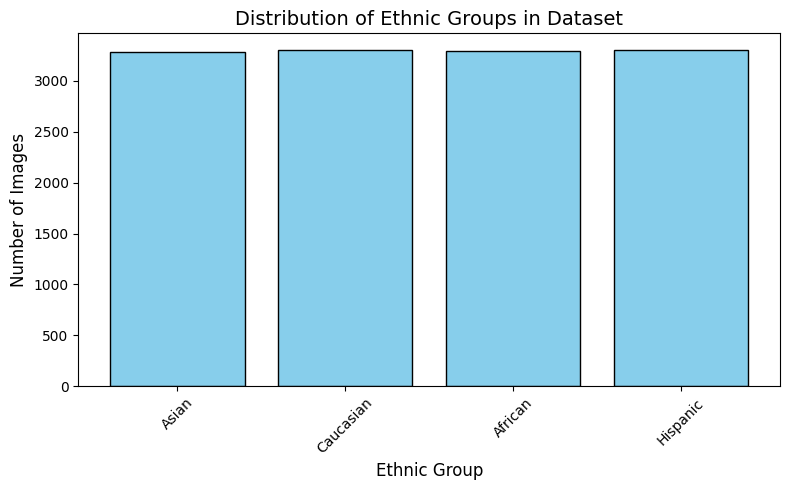

In [1]:
import os
import matplotlib.pyplot as plt

# Path to your dataset
dataset_path = './data/utk_races/balanced_train'

# Define a mapping from numeric labels to ethnic group names
label_to_ethnicity = {
    '0': 'Asian',
    '1': 'Caucasian',
    '2': 'African',
    '3': 'Hispanic'
}

# Dictionary to count images per ethnicity
ethnicity_counts = {label_to_ethnicity[label]: 0 for label in label_to_ethnicity}

# Count images for each label
for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):  # Ensure it's a directory
        # Get the list of files in the folder
        files = [f for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))]
        num_images = len(files)
        
        # Debug: Print counts for each folder
        print(f"Label: {label}, Ethnicity: {label_to_ethnicity.get(label, 'Unknown')}, Count: {num_images}")
        
        ethnicity_name = label_to_ethnicity.get(label, f'Unknown ({label})')
        ethnicity_counts[ethnicity_name] += num_images

# Data for the histogram
ethnicities = list(ethnicity_counts.keys())
counts = list(ethnicity_counts.values())

# Plot the histogram
plt.figure(figsize=(8, 5))
plt.bar(ethnicities, counts, color='skyblue', edgecolor='black')
plt.title('Distribution of Ethnic Groups in Dataset', fontsize=14)
plt.xlabel('Ethnic Group', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


In [12]:
import tensorflow as tf

# Define dataset paths
train_dir = "./data/utk_races/balancedagain"
val_dir = "./data/utk_races/val"

# Create datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),  # Resize images to 224x224
    batch_size=32          # Define batch size
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=32
)

# Inspect dataset
for images, labels in train_dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")


Found 24132 files belonging to 4 classes.
Found 4402 files belonging to 4 classes.
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


### CNN model

In [13]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from keras.optimizers import SGD
from keras.models import Model

def conv_block(inp, filters=32, bn=True, pool=True):
    _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

input_layer = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
_ = conv_block(input_layer, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3)
_ = conv_block(_, filters=32*4)
_ = conv_block(_, filters=32*5)
_ = conv_block(_, filters=32*6)
bottleneck = GlobalMaxPool2D()(_)

# for age calculation
_ = Dense(units=128, activation='relu')(bottleneck)
age_output = Dense(units=1, activation='sigmoid', name='age_output')(_)

# for race prediction
_ = Dense(units=128, activation='relu')(bottleneck)
race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(_)

# for gender prediction
_ = Dense(units=128, activation='relu')(bottleneck)
gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(_)

model = Model(inputs=input_layer, outputs=[age_output, race_output, gender_output])
model.compile(optimizer='rmsprop', 
              loss={'age_output': 'mse', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},
              metrics={'age_output': 'mae', 'race_output': 'accuracy', 'gender_output': 'accuracy'})
# model.summary()

In [14]:
IM_HEIGHT = 224  # Define image height
IM_WIDTH = 224   # Define image width

input_layer = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))  # Input layer with image dimensions
_ = conv_block(input_layer, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3)
_ = conv_block(_, filters=32*4)
_ = conv_block(_, filters=32*5)
_ = conv_block(_, filters=32*6)
bottleneck = GlobalMaxPool2D()(_)

# for age calculation
_ = Dense(units=128, activation='relu')(bottleneck)
age_output = Dense(units=1, activation='sigmoid', name='age_output')(_)

# for race prediction
RACE_ID_MAP = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Other'}  # Example mapping
_ = Dense(units=128, activation='relu')(bottleneck)
race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(_)

# for gender prediction
GENDER_ID_MAP = {0: 'Male', 1: 'Female'}  # Example mapping
_ = Dense(units=128, activation='relu')(bottleneck)
gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(_)

model = Model(inputs=input_layer, outputs=[age_output, race_output, gender_output])
model.compile(optimizer='rmsprop', 
              loss={'age_output': 'mse', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},
              metrics={'age_output': 'mae', 'race_output': 'accuracy', 'gender_output': 'accuracy'})
# model.summary()


### Training

In [15]:
import tensorflow as tf

def get_data_generator(df, idx, for_training=True, batch_size=64):
    while True:  # Loop forever so the generator doesn't stop
        batch_data = []  # This will hold your data
        for i in range(batch_size):
            # Fetch data (you can adjust this as per your data)
            data = df.iloc[idx[i]]  # Example, adjust as needed
            batch_data.append(data)  # Add to batch
        
        # Convert the batch to a tensor (this is important)
        yield tf.convert_to_tensor(batch_data)


In [16]:
data_shape = (224,224,3)  # Replace with actual shape of a single data sample


In [17]:
import tensorflow as tf

def get_data_generator(df, indices, for_training=True, batch_size=32):
    # Generate the data (this is just an example, adjust based on your data loading)
    # For example, assuming you load images from paths in 'df' based on 'indices'
    
    def load_and_preprocess_image(image_path):
        # Read the image
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        
        # Resize the image to match model input shape (198x198)
        image = tf.image.resize(image, [198, 198])  # Resize to (198, 198)
        
        # Normalize the image (if required)
        image = image / 255.0  # Normalize to [0, 1] range
        
        return image

    # Define your data generator here, ensure the images are resized
    def data_gen():
        for i in indices:
            # Assuming 'df' has a column 'image_path' for image paths
            image = load_and_preprocess_image(df.iloc[i]['./data/utk_races/train'])
            label = df.iloc[i]['data/utk_races/train']  # Adjust for your label extraction method
            yield image, label

    return tf.data.Dataset.from_generator(
        data_gen,
        output_signature=(tf.TensorSpec(shape=(198, 198, 3), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.int32))
    ).batch(batch_size)


In [18]:
from tensorflow.keras import layers, models

num_classes = 4 # Change this to the actual number of classes in your dataset

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),  # Input size (224x224 RGB images)
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # The number of classes here
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image generators for training and validation data
train_datagen = ImageDataGenerator(rescale=1./255,  # Rescaling the images to [0, 1]
                                   shear_range=0.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Assuming you have your data in directories 'train' and 'validation'
train_generator = train_datagen.flow_from_directory(
    './data/utk_races/balancedagain',  # Provide path to your training data
    target_size=(224, 224),  # Resize images to (224, 224)
    batch_size=32,          # Choose your batch size
    class_mode='categorical'  # This should be categorical for multi-class classification
)

validation_generator = valid_datagen.flow_from_directory(
    './data/utk_races/val',  # Provide path to your validation data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 24132 images belonging to 4 classes.
Found 4402 images belonging to 4 classes.


In [22]:
from keras.callbacks import ModelCheckpoint

history = model.fit(
    train_generator,  # The training data generator
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Number of steps per epoch
    epochs=10,  # Set the number of epochs to train the model
    validation_data=validation_generator,  # The validation data generator
    validation_steps=validation_generator.samples // validation_generator.batch_size,  # Number of validation steps per epoch
    callbacks=[ModelCheckpoint('mymodel11.keras', monitor='val_loss', save_best_only=True)]  # Optional callback to save the best model
)


Epoch 1/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 421s 558ms/step - accuracy: 0.4625 - loss: 1.2451 - val_accuracy: 0.6982 - val_loss: 0.7822
Epoch 2/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 1s 150us/step - accuracy: 0.5625 - loss: 1.0366 - val_accuracy: 0.6667 - val_loss: 0.8965
Epoch 3/10


c:\Users\ANKITA DAS\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


754/754 ━━━━━━━━━━━━━━━━━━━━ 403s 535ms/step - accuracy: 0.6680 - loss: 0.8430 - val_accuracy: 0.6369 - val_loss: 0.9328
Epoch 4/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 65us/step - accuracy: 0.6250 - loss: 0.8313 - val_accuracy: 0.6111 - val_loss: 1.1393
Epoch 5/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 396s 526ms/step - accuracy: 0.7217 - loss: 0.7450 - val_accuracy: 0.7356 - val_loss: 0.6913
Epoch 6/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 104us/step - accuracy: 0.6875 - loss: 0.8603 - val_accuracy: 0.6667 - val_loss: 0.7578
Epoch 7/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 400s 530ms/step - accuracy: 0.7393 - loss: 0.6936 - val_accuracy: 0.7568 - val_loss: 0.6373
Epoch 8/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6875 - loss: 1.0218 - val_accuracy: 0.9444 - val_loss: 0.4009
Epoch 9/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 406s 539ms/step - accuracy: 0.7563 - loss: 0.6618 - val_accuracy: 0.7486 - val_loss: 0.6827
Epoch 10/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 92us/step - accuracy: 0.7500 - loss: 0.5597 - val_ac

Evaluation


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the test data generator (assuming test images are in 'test' directory)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Rescaling pixel values to [0, 1]

test_generator = test_datagen.flow_from_directory(
    './data/utk_races/test',  # Replace with your test folder path
    target_size=(224, 224),  # Resize the images if necessary
    batch_size=32,  # Define the batch size
    class_mode='categorical',  # 'categorical' for multi-class classification
    shuffle=False  # No need to shuffle for evaluation
)


Found 4404 images belonging to 4 classes.


In [26]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc * 100:.2f}%')


137/137 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 0.6769 - loss: 0.8636
Test accuracy: 74.48%


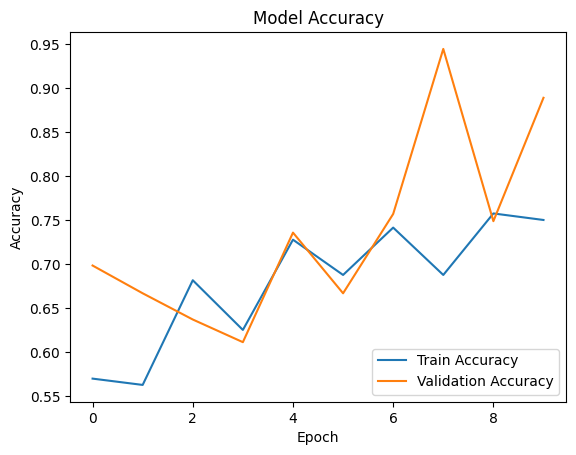

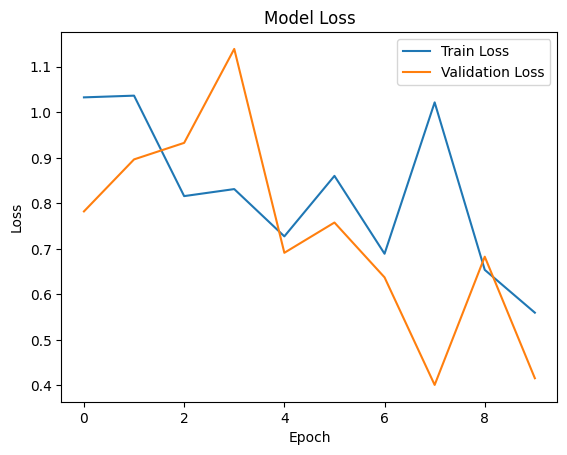

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.69      0.78      2039
           1       0.83      0.77      0.80       873
           2       0.60      0.83      0.69       711
           3       0.57      0.79      0.67       781

    accuracy                           0.74      4404
   macro avg       0.73      0.77      0.74      4404
weighted avg       0.79      0.74      0.75      4404



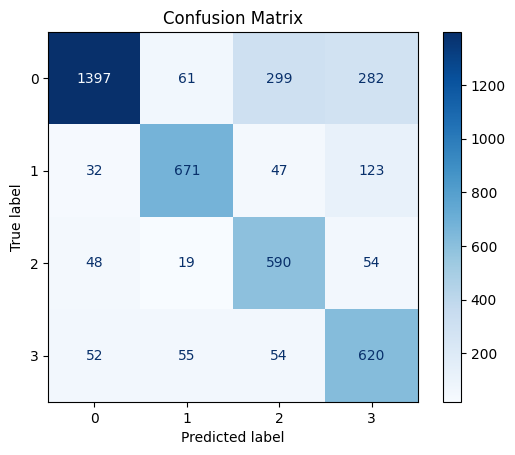

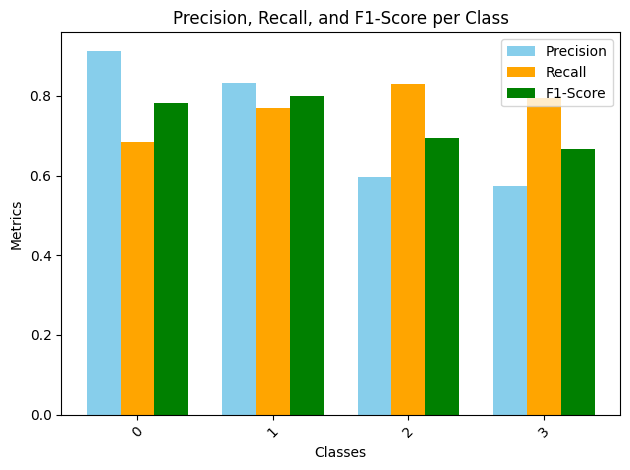

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on the test data
y_true = test_generator.classes  # True labels
y_pred_probs = model.predict(test_generator)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class indices

# Class names (optional, extracted from test_generator)
class_names = list(test_generator.class_indices.keys())

# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Optional: Plot Precision, Recall, and F1-score as a bar chart
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Extract metrics for each class
precision = [report[label]['precision'] for label in class_names]
recall = [report[label]['recall'] for label in class_names]
f1_score = [report[label]['f1-score'] for label in class_names]

# Bar chart for precision, recall, and F1-score
x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, precision, width, label='Precision', color='skyblue')
plt.bar(x, recall, width, label='Recall', color='orange')
plt.bar(x + width, f1_score, width, label='F1-Score', color='green')

plt.xlabel('Classes')
plt.ylabel('Metrics')
plt.title('Precision, Recall, and F1-Score per Class')
plt.xticks(x, class_names, rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


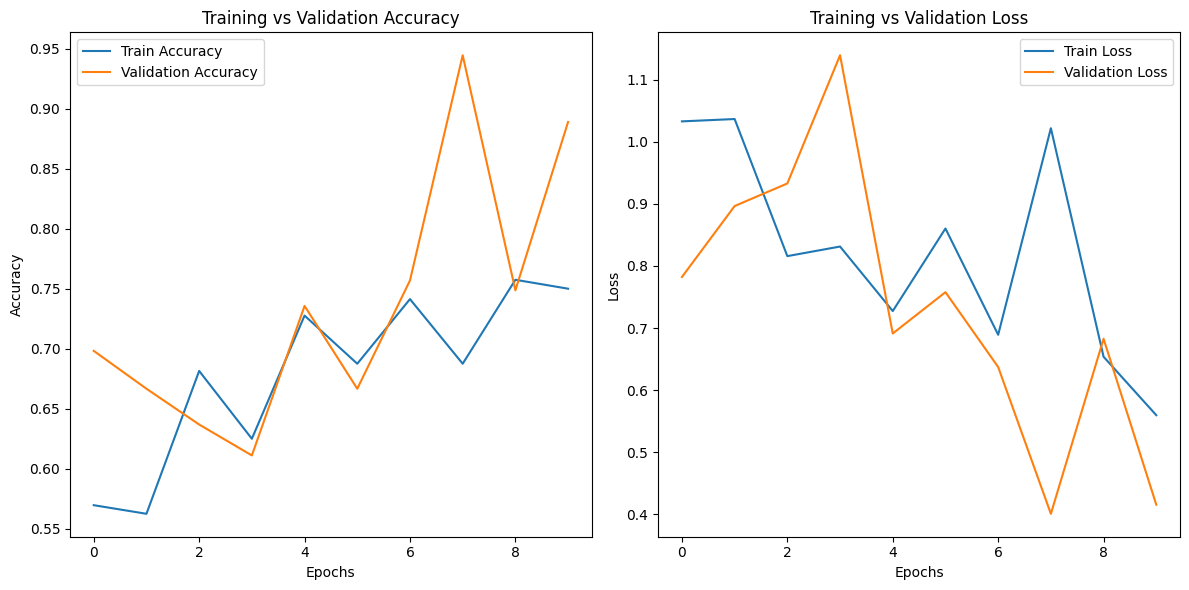

In [28]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# Training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [29]:
# Save the model
model.save('ethnicityankita_modelok.keras')


Integrating the model with Webcam

In [32]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load the trained model
model = load_model('./ethnicityankita_modelok.keras')

# Define the ethnicity labels
ethnicity_labels = ['Asian', 'Caucasian', 'African', 'Other', 'Hispanic']

# Initialize the webcam
cap = cv2.VideoCapture(0)  # 0 is the default webcam; change if using an external camera

# Define a function to preprocess the frame
def preprocess_frame(frame):
    # Convert the frame to RGB (OpenCV captures in BGR by default)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Resize the frame to match the model input size (224x224)
    resized_frame = cv2.resize(frame_rgb, (224, 224))
    # Normalize pixel values to [0, 1]
    normalized_frame = resized_frame / 255.0
    # Convert to array and add batch dimension
    return np.expand_dims(normalized_frame, axis=0)

while True:
    # Capture a frame from the webcam
    ret, frame = cap.read()
    if not ret:
        break  # Exit the loop if the frame can't be read

    # Preprocess the frame
    preprocessed_frame = preprocess_frame(frame)

    # Make a prediction using the model
    prediction = model.predict(preprocessed_frame)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Get the label of the predicted class
    ethnicity = ethnicity_labels[predicted_class]

    # Display the prediction on the frame
    text = f'Ethnicity: {ethnicity}'
    cv2.putText(frame, text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Show the frame in a window
    cv2.imshow('Ethnicity Detection', frame)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close the OpenCV window
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━